## Initialization

In [501]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz, DecisionTreeRegressor
import pandas as pd
import numpy as np
YR = 2010
TEST_RATIO = 0.7
PARTITION = int(TEST_RATIO*min(uscbYr.shape[0], edf.shape[0]))
INPUT_PATH = f'../2019_MCMProblemC_DATA/ACS_{YR%2000}_5YR_DP02/ACS_{YR%2000}_5YR_DP02_with_ann.csv'
EXPECTED_PATH = '../2019_MCMProblemC_DATA/MCM_NFLIS_Data.xlsx'
uscbYr = pd.read_csv(INPUT_PATH)
edf = pd.read_excel(EXPECTED_PATH, 'Data')
uscbTbl = uscbYr.rename(columns=uscbYr.iloc[0]).drop([0])
uscbYr = uscbYr.drop([0])

In [502]:
STATE_CODES = {
    'Virginia' : 'VA',
    'Ohio' : 'OH',
    'Kentucky' : 'KY',
    'Pennsylvania' : 'PA',
    'West Virginia' : 'WV'
}

In [503]:
def sumRowsDF(df):
    return df.apply(pd.to_numeric).sum(axis=1)

## Prepare Dataset

In [504]:
# get counties
counties = uscbYr.iloc[:,2]
# group marital status
divorced = sumRowsDF(uscbYr.loc[:, ['HC01_VC37', 'HC01_VC38', 'HC01_VC39']])
# group education attainment
notCollegeGrad = sumRowsDF(uscbYr.loc[:, ['HC01_VC85', 'HC01_VC86', 'HC01_VC87', 'HC01_VC88']])
collegeGrad = sumRowsDF(uscbYr.loc[:, ['HC01_VC89', 'HC01_VC90', 'HC01_VC91']])
# group ethnicity
arab = uscbYr.loc[:, 'HC01_VC184']

africa = uscbYr.loc[:, 'HC01_VC204']

europe = sumRowsDF(uscbYr.loc[:, [
    'HC01_VC186', 
    'HC01_VC187', 
    'HC01_VC189', 
    'HC01_VC191',
    'HC01_VC192',
    'HC01_VC194',
    'HC01_VC195',
    'HC01_VC196',
    'HC01_VC197',
    'HC01_VC198',
    'HC01_VC199',
    'HC01_VC201',
    'HC01_VC202',
    'HC01_VC205',
    'HC01_VC206',
    'HC01_VC208'
]])
slavonic = sumRowsDF(uscbYr.loc[:, [
    'HC01_VC185', 
    'HC01_VC193', 
    'HC01_VC200', 
    'HC01_VC203',
    'HC01_VC207'
]])
na = sumRowsDF(uscbYr.loc[:, [
    'HC01_VC188',
    'HC01_VC190',
    'HC01_VC209'
]])
generalStats = uscbYr.loc[:, [
    'GEO.id2',
    'HC01_VC03', 
    'HC01_VC20', 
    'HC01_VC36',
    'HC01_VC37',
    'HC01_VC54',
    'HC01_VC52'
]]
cleanedData = pd.concat([
    generalStats, 
    divorced,
    notCollegeGrad,
    collegeGrad,
    arab,
    africa,
    europe,
    slavonic,
    na
], axis=1)
cleanedData = cleanedData.rename(columns={"GEO.id2": "FIPS_Combined"})

In [505]:
edf = edf[edf['YYYY'] == YR]
edf = edf.loc[:, ['FIPS_Combined', 'TotalDrugReportsCounty']].drop_duplicates()

In [506]:
cleanedData['FIPS_Combined'] = cleanedData['FIPS_Combined'].apply(int)
totalData = cleanedData.merge(edf, left_on='FIPS_Combined', right_on='FIPS_Combined')

In [507]:
X = totalData.drop(['FIPS_Combined', 'TotalDrugReportsCounty'], axis=1).apply(pd.to_numeric).values
y = totalData.loc[:, totalData.columns == 'TotalDrugReportsCounty'].values.T[0]
X_train, y_train = X[:PARTITION], y[:PARTITION]
X_val, y_val = X[PARTITION:], y[PARTITION:]

## Run Random Forest and Decision Tree Regression

In [509]:
rnd_rg = RandomForestRegressor(n_estimators=1, max_leaf_nodes=16, n_jobs=-1)
d_tree = DecisionTreeRegressor(max_depth=8)
rnd_rg.fit(X_train, y_train)
d_tree.fit(X_train, y_train)
y_pred_rf = rnd_rg.predict(X_val)

## Results

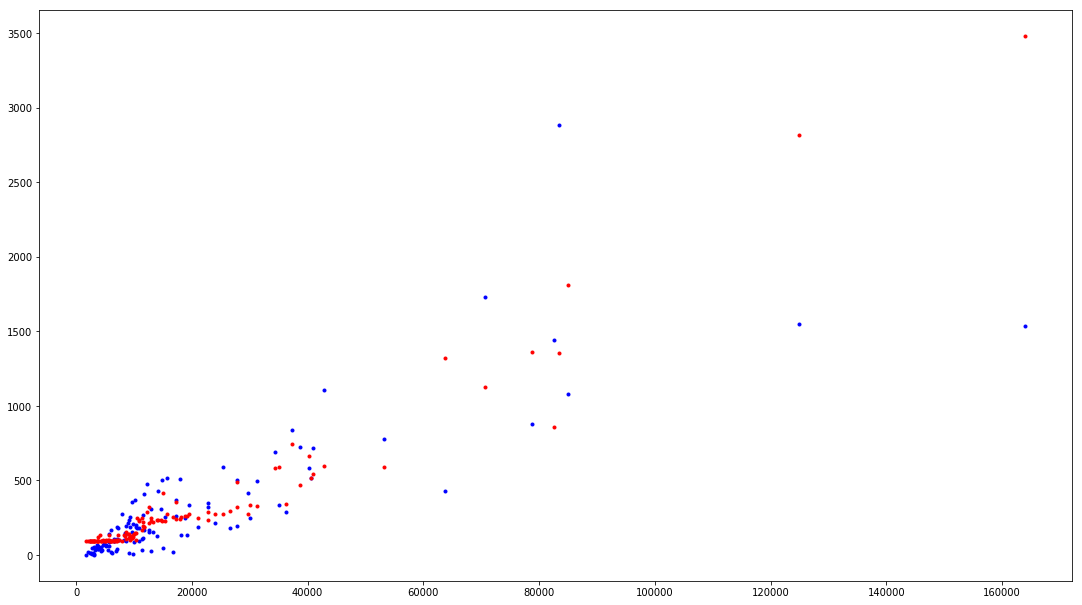

In [492]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools
x = X_val.T[0]
tick_spacing = 10
fig, ax = plt.subplots(1,1)
ax.plot(x, y_val, "b.")
ax.plot(x, y_pred_rf, "r.")
fig.set_size_inches(18.5, 10.5)
plt.show()

In [513]:
export_graphviz(
    d_tree,
    feature_names=[
        'Total households', 
        'Avg household size',
        'Never married',
        'Married not separated',
        'Fertility / 1k women',
        'Fertility of unmarried wmn',
        'Divorced',
        'No College Degree',
        'Has College Degree',
        'Arab ancestry',
        'Subsah. African ancestry',
        'European ancestry',
        'Slavonic ancestry',
        'North Amer. ancestry'
    ],
    out_file="../generated_data/reg_tree.dot",
    rounded=True,
    filled=True
)